#### 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import pickle
### 전처리
# 경사도, 배수등급 '기타' 처리
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
# 스케일링
from sklearn.preprocessing import StandardScaler
### 모델링
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
# 모델들
from sklearn.neighbors import KNeighborsClassifier
import sklearn.discriminant_analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
# Tree 시각화
from sklearn.tree import export_graphviz
from subprocess import check_call
from graphviz import Source
from IPython.display import Image
# 업샘플링
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
!apt-get -qq install fonts-nanum

Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


#### 데이터 불러오기~

In [ ]:
pothole = pd.read_pickle('/content/drive/MyDrive/DATA_완성/pothole_예측용.pickle')

In [ ]:
pothole['발생여부'] = np.where(pothole['포트홀 갯수'] >=1, 1, 0)
pothole.columns

Index(['자치구', '행정동', '경도', '위도', '차선수', '승용차', '버스', '트럭', '총교통량', '중대형차량 교통량',
       '포트홀 갯수', '평균_건물연령', '등록번호', '발생일', '인구 수', '누적 강수량', '평균 습도', '1년 기온차',
       '평균 일교차', '배수등급', '경사도', '자치구_enc', '발생여부'],
      dtype='object')

### x, y 할당

 - x : 자치구/행정동/경도/위도/등록번호/발생일 - 삭제
 - y : 포트홀 존재 여부

In [ ]:
### x, y 할당
x = pothole.drop(['자치구', '행정동', '경도', '위도', '등록번호', '발생일', '자치구_enc', '총교통량', '중대형차량 교통량', '포트홀 갯수', '발생여부'], axis=1)
y = pothole['발생여부']
x.head(2)

,차선수,승용차,버스,트럭,평균_건물연령,인구 수,누적 강수량,평균 습도,1년 기온차,평균 일교차,배수등급,경사도
0,1.0,-0.355737,-0.057007,-0.295055,-0.363365,0.928563,-0.599417,-0.038033,-1.144723,0.668894,4.0,2.0
1,1.0,-0.355737,-0.057007,-0.295055,-0.363365,0.928563,-0.599417,-0.038033,-1.144723,0.668894,4.0,4.0


In [ ]:
### 날씨 제어해서
x2 = x.drop(['누적 강수량', '평균 습도', '1년 기온차', '평균 일교차'], axis = 1)
x2.head(2)

,차선수,승용차,버스,트럭,총교통량,중대형차량 교통량,평균_건물연령,인구 수,배수등급,경사도
0,3.0,0.158441,1.284569,0.160536,0.206347,0.686938,-0.581126,-2.223687,2.0,0.0
1,4.0,0.579167,1.416807,0.494772,0.609744,0.394627,-0.581126,-2.223687,2.0,0.0


In [ ]:
### train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 1384)

### Original Data

#### KNN

In [ ]:
####### KNN ##########################
### fitting
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(x_train, y_train)
### prediction
knn_pred = knn_model.predict(x_test)
knn_pred_prob = knn_model.predict_proba(x_test)[:,1]
### accuracy
knn_acc = accuracy_score(y_test, knn_pred)
knn_auc = roc_auc_score(y_test, knn_pred_prob)
print("KNN - Accuracy : {:.4f}". format(knn_acc))
print("KNN - AUC : {:.4f}". format(knn_auc))

KNN - Accuracy : 0.9755
KNN - AUC : 0.9857


#### LDA/QDA

- LDA

In [ ]:
####### LDA ##########################
### fitting
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(x_train, y_train)
### prediction
lda_pred = lda_model.predict(x_test)
lda_pred_prob = lda_model.predict_proba(x_test)[:,1]
### accuracy
lda_acc = accuracy_score(y_test, lda_pred)
lda_auc = roc_auc_score(y_test, lda_pred_prob)
print("LDA - Accuracy : {:.4f}". format(lda_acc))
print("LDA - AUC : {:.4f}". format(lda_auc))

LDA - Accuracy : 0.9106
LDA - AUC : 0.9552


- QDA

In [ ]:
####### QDA ##########################
### fitting
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(x_train, y_train)
### prediction
qda_pred = qda_model.predict(x_test)
qda_pred_prob = qda_model.predict_proba(x_test)[:,1]
### accuracy
qda_acc = accuracy_score(y_test, qda_pred)
qda_auc = roc_auc_score(y_test, qda_pred_prob)
print("QDA - Accuracy : {:.4f}". format(qda_acc))
print("QDA - AUC : {:.4f}". format(qda_auc))

QDA - Accuracy : 0.9539
QDA - AUC : 0.9900


#### Tree

In [ ]:
### Hyperparameter - 일단은 train 기준으로만
depths = {'max_depth' : range(5,15)}
tree_cv = GridSearchCV(DecisionTreeClassifier(), param_grid = depths, cv = 5)
tree_cv.fit(x_train, y_train)

print('GridSearch 최고 평균 정확도 : {:.4f}'. format(tree_cv.best_score_))
print('GridSearch 최적 파라미터 : ', tree_cv.best_params_)

GridSearch 최고 평균 정확도 : 0.9957
GridSearch 최적 파라미터 :  {'max_depth': 9}


In [ ]:
####### Tree ##########################
### fitting
tree_model = DecisionTreeClassifier(max_depth = 9)
tree_model.fit(x_train, y_train)
### prediction
tree_pred = tree_model.predict(x_test)
tree_pred_prob = tree_model.predict_proba(x_test)[:,1]
### accuracy
tree_acc = accuracy_score(y_test, tree_pred)
tree_auc = roc_auc_score(y_test, tree_pred_prob)
print("Tree - Accuracy : {:.4f}". format(tree_acc))
print("Tree - AUC : {:.4f}".format(tree_auc))

Tree - Accuracy : 0.9933
Tree - AUC : 0.9983


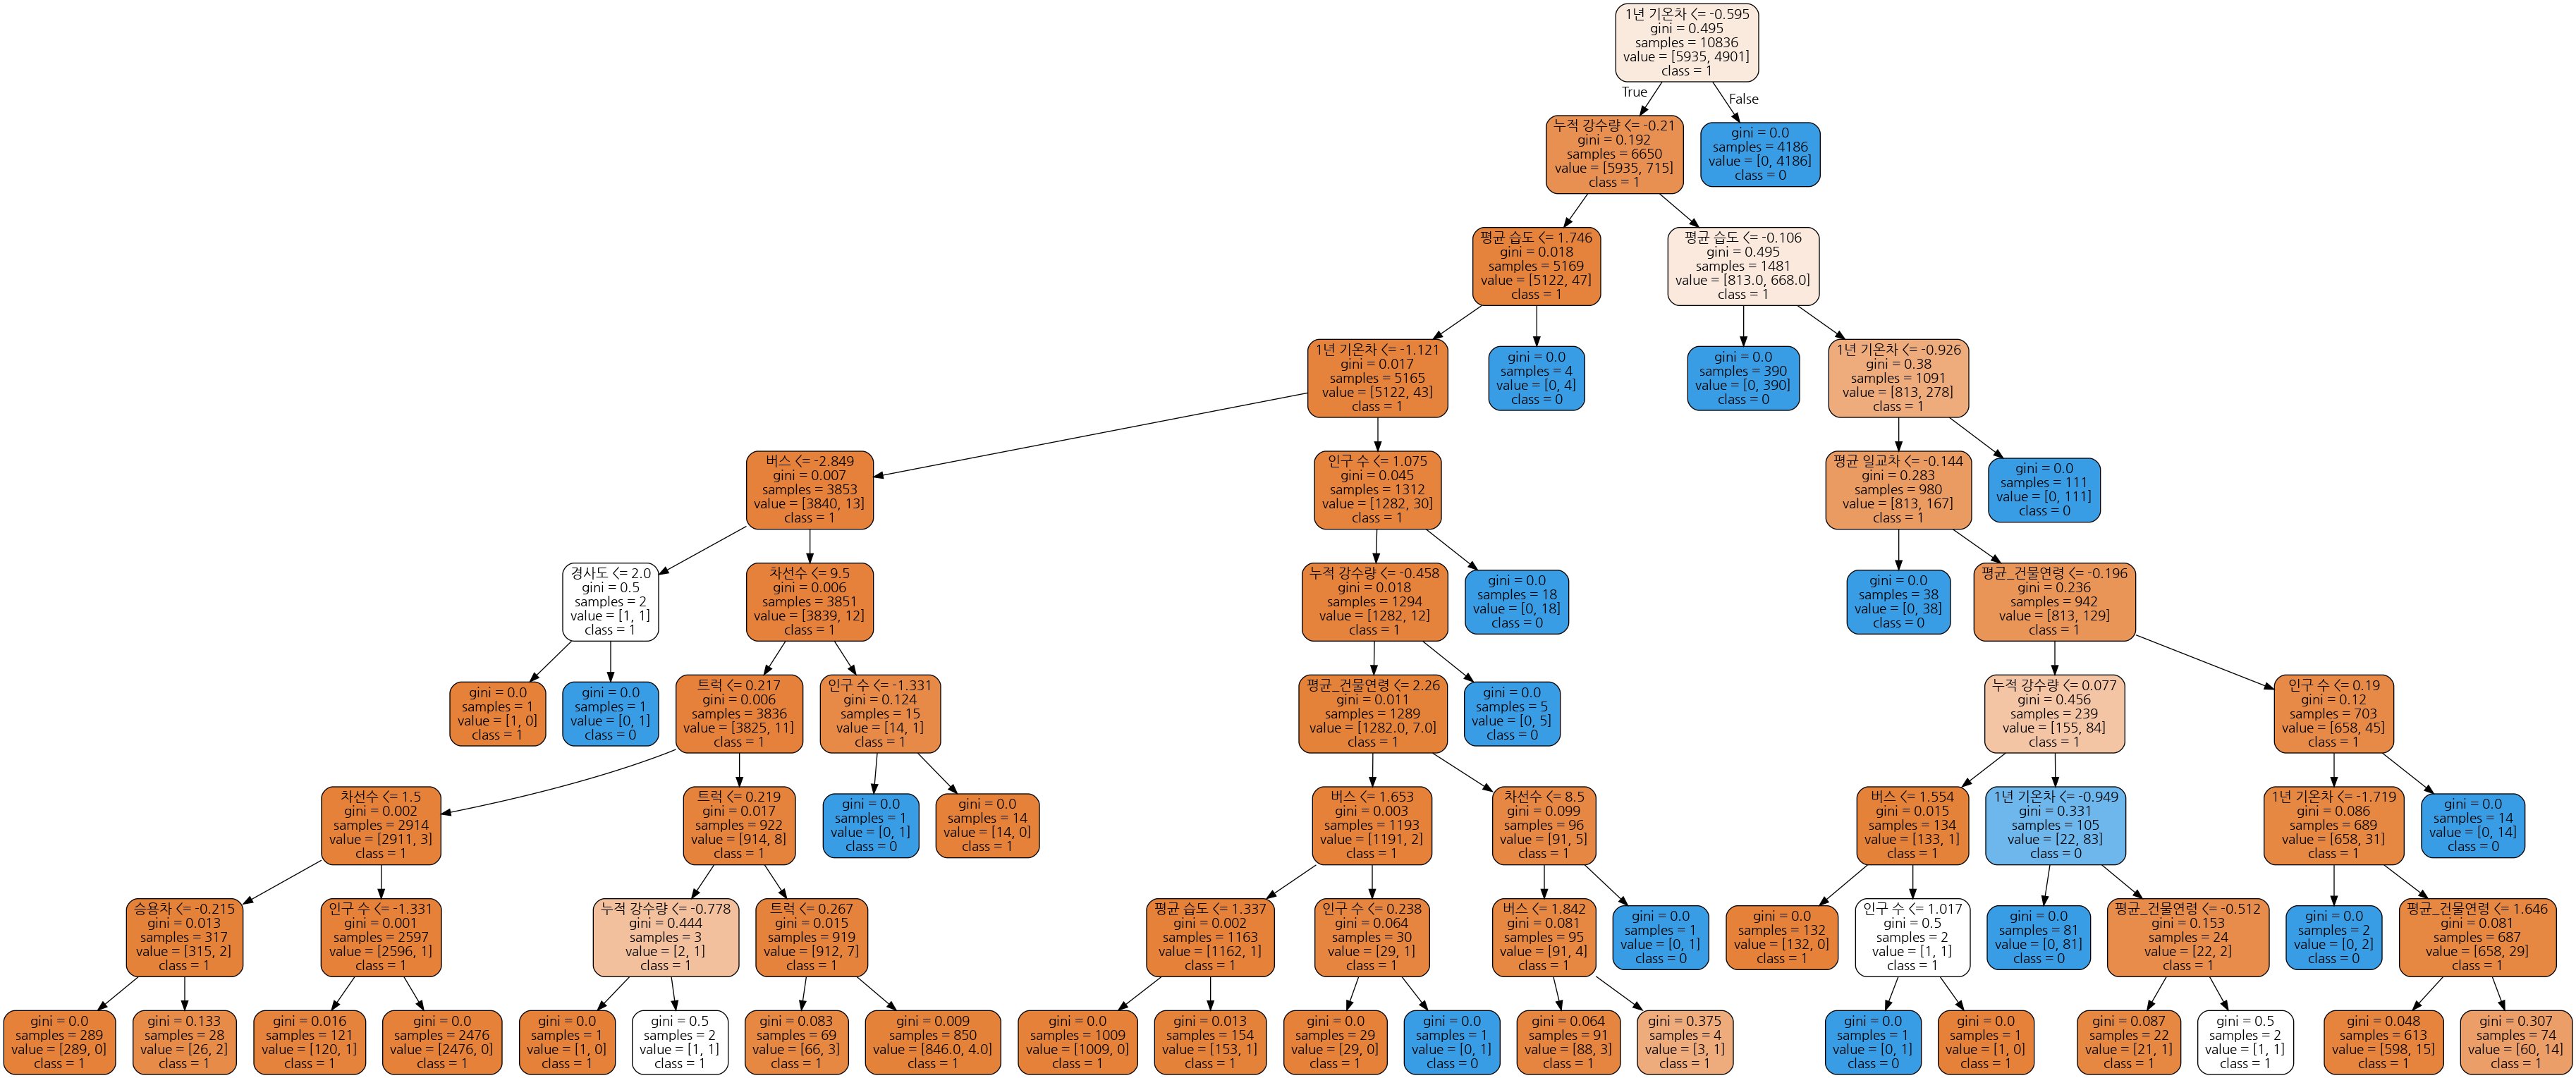

In [ ]:
tree_model_dot = export_graphviz(tree_model,
                                 out_file = None,
                                 class_names = [str(cls) for cls in y_train.unique()],
                                feature_names = x_train.columns,
                                 rounded = True, filled = True, fontname="NanumGothic")
graph = Source(tree_model_dot)
graph.render("tree_model", format = "png")
Image(filename = "tree_model.png")

In [ ]:
### FNR, Precision, F1 Score
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score

confusion = confusion_matrix(y_test, tree_pred)
tn, fp, fn, tp = confusion.ravel()
tree_fnr = fn / (fn + tp)
tree_precision = precision_score(y_test, tree_pred)
tree_f1 = f1_score(y_test, tree_pred)

print(f"Tree - FNR       : {tree_fnr:.4f}")
print(f"Tree - Precision : {tree_precision:.4f}")
print(f"Tree - F1 score  : {tree_f1:.4f}")

Tree - FNR       : 0.0148
Tree - Precision : 1.0000
Tree - F1 score  : 0.9926


### Up-Sampling

In [ ]:
pothole['발생여부'].value_counts()

,count
발생여부,
0,8478
1,7002


- 찾아보니 train에만 업샘플링하는 게 맞다고 해서.. 일단은 그렇게 진행

In [ ]:
### SMOTE
smote = SMOTE(random_state = 1392)
x_train_up, y_train_up = smote.fit_resample(x_train, y_train)

#### KNN

In [ ]:
####### KNN ##########################
### fitting
knn_model_up = KNeighborsClassifier(n_neighbors = 3)
knn_model_up.fit(x_train_up, y_train_up)
### prediction
knn_pred_up = knn_model_up.predict(x_test)
knn_pred_prob_up = knn_model_up.predict_proba(x_test)[:,1]
### accuracy
knn_acc_up = accuracy_score(y_test, knn_pred_up)
knn_roc_up = roc_auc_score(y_test, knn_pred_prob_up)
print("KNN_up - Accuracy : {:.4f}". format(knn_acc_up))
print("KNN_up - AUC : {:.4f}". format(knn_roc_up))

KNN_up - Accuracy : 0.9761
KNN_up - AUC : 0.9859


#### LDA/QDA

In [ ]:
####### LDA ##########################
### fitting
lda_model_up = LinearDiscriminantAnalysis()
lda_model_up.fit(x_train_up, y_train_up)
### prediction
lda_pred_up = lda_model_up.predict(x_test)
lda_pred_prob_up = lda_model_up.predict_proba(x_test)[:,1]
### accuracy
lda_acc_up = accuracy_score(y_test, lda_pred_up)
lda_roc_up = roc_auc_score(y_test, lda_pred_prob_up)
print("LDA_up - Accuracy : {:.4f}". format(lda_acc_up))
print("LDA_up - AUC : {:.4f}". format(lda_roc_up))

LDA_up - Accuracy : 0.9139
LDA_up - AUC : 0.9566


In [ ]:
####### QDA ##########################
### fitting
qda_model_up = QuadraticDiscriminantAnalysis()
qda_model_up.fit(x_train_up, y_train_up)
### prediction
qda_pred_up = qda_model_up.predict(x_test)
qda_pred_prob_up = qda_model_up.predict_proba(x_test)[:,1]
### accuracy
qda_acc_up = accuracy_score(y_test, qda_pred_up)
qda_roc_up = roc_auc_score(y_test, qda_pred_prob_up)
print("QDA_up - Accuracy : {:.4f}". format(qda_acc_up))
print("QDA_up - AUC : {:.4f}". format(qda_roc_up))

QDA_up - Accuracy : 0.9546
QDA_up - AUC : 0.9900


#### Tree

In [ ]:
### Hyperparameter - 일단은 train 기준으로만
depths = {'max_depth' : range(5,15)}
tree_cv_up = GridSearchCV(DecisionTreeClassifier(), param_grid = depths, cv = 5)
tree_cv_up.fit(x_train_up, y_train_up)

print('GridSearch_up 최고 평균 정확도 : {:.4f}'. format(tree_cv_up.best_score_))
print('GridSearch_up 최적 파라미터 : ', tree_cv_up.best_params_)

GridSearch_up 최고 평균 정확도 : 0.9961
GridSearch_up 최적 파라미터 :  {'max_depth': 10}


In [ ]:
####### Tree ##########################
### fitting
tree_model_up = DecisionTreeClassifier(max_depth = 10)
tree_model_up.fit(x_train_up, y_train_up)
### prediction
tree_pred_up = tree_model_up.predict(x_test)
tree_pred_prob_up = tree_model_up.predict_proba(x_test)[:,1]
### accuracy
tree_acc_up = accuracy_score(y_test, tree_pred_up)
tree_auc_up = roc_auc_score(y_test, tree_pred_prob_up)
print("Tree_up - Accuracy : {:.4f}". format(tree_acc_up))
print("Tree_up - AUC : {:.4f}".format(tree_auc_up))

Tree_up - Accuracy : 0.9950
Tree_up - AUC : 0.9982


In [ ]:
### FNR, Precision, F1 Score
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score

confusion = confusion_matrix(y_test, tree_pred_up)
tn, fp, fn, tp = confusion.ravel()
tree_fnr_up = fn / (fn + tp)
tree_precision_up = precision_score(y_test, tree_pred_up)
tree_f1_up = f1_score(y_test, tree_pred_up)

print(f"Tree_up - FNR       : {tree_fnr_up:.4f}")
print(f"Tree_up - Precision : {tree_precision_up:.4f}")
print(f"Tree_up - F1 score  : {tree_f1_up:.4f}")

Tree_up - FNR       : 0.0095
Tree_up - Precision : 0.9986
Tree_up - F1 score  : 0.9945


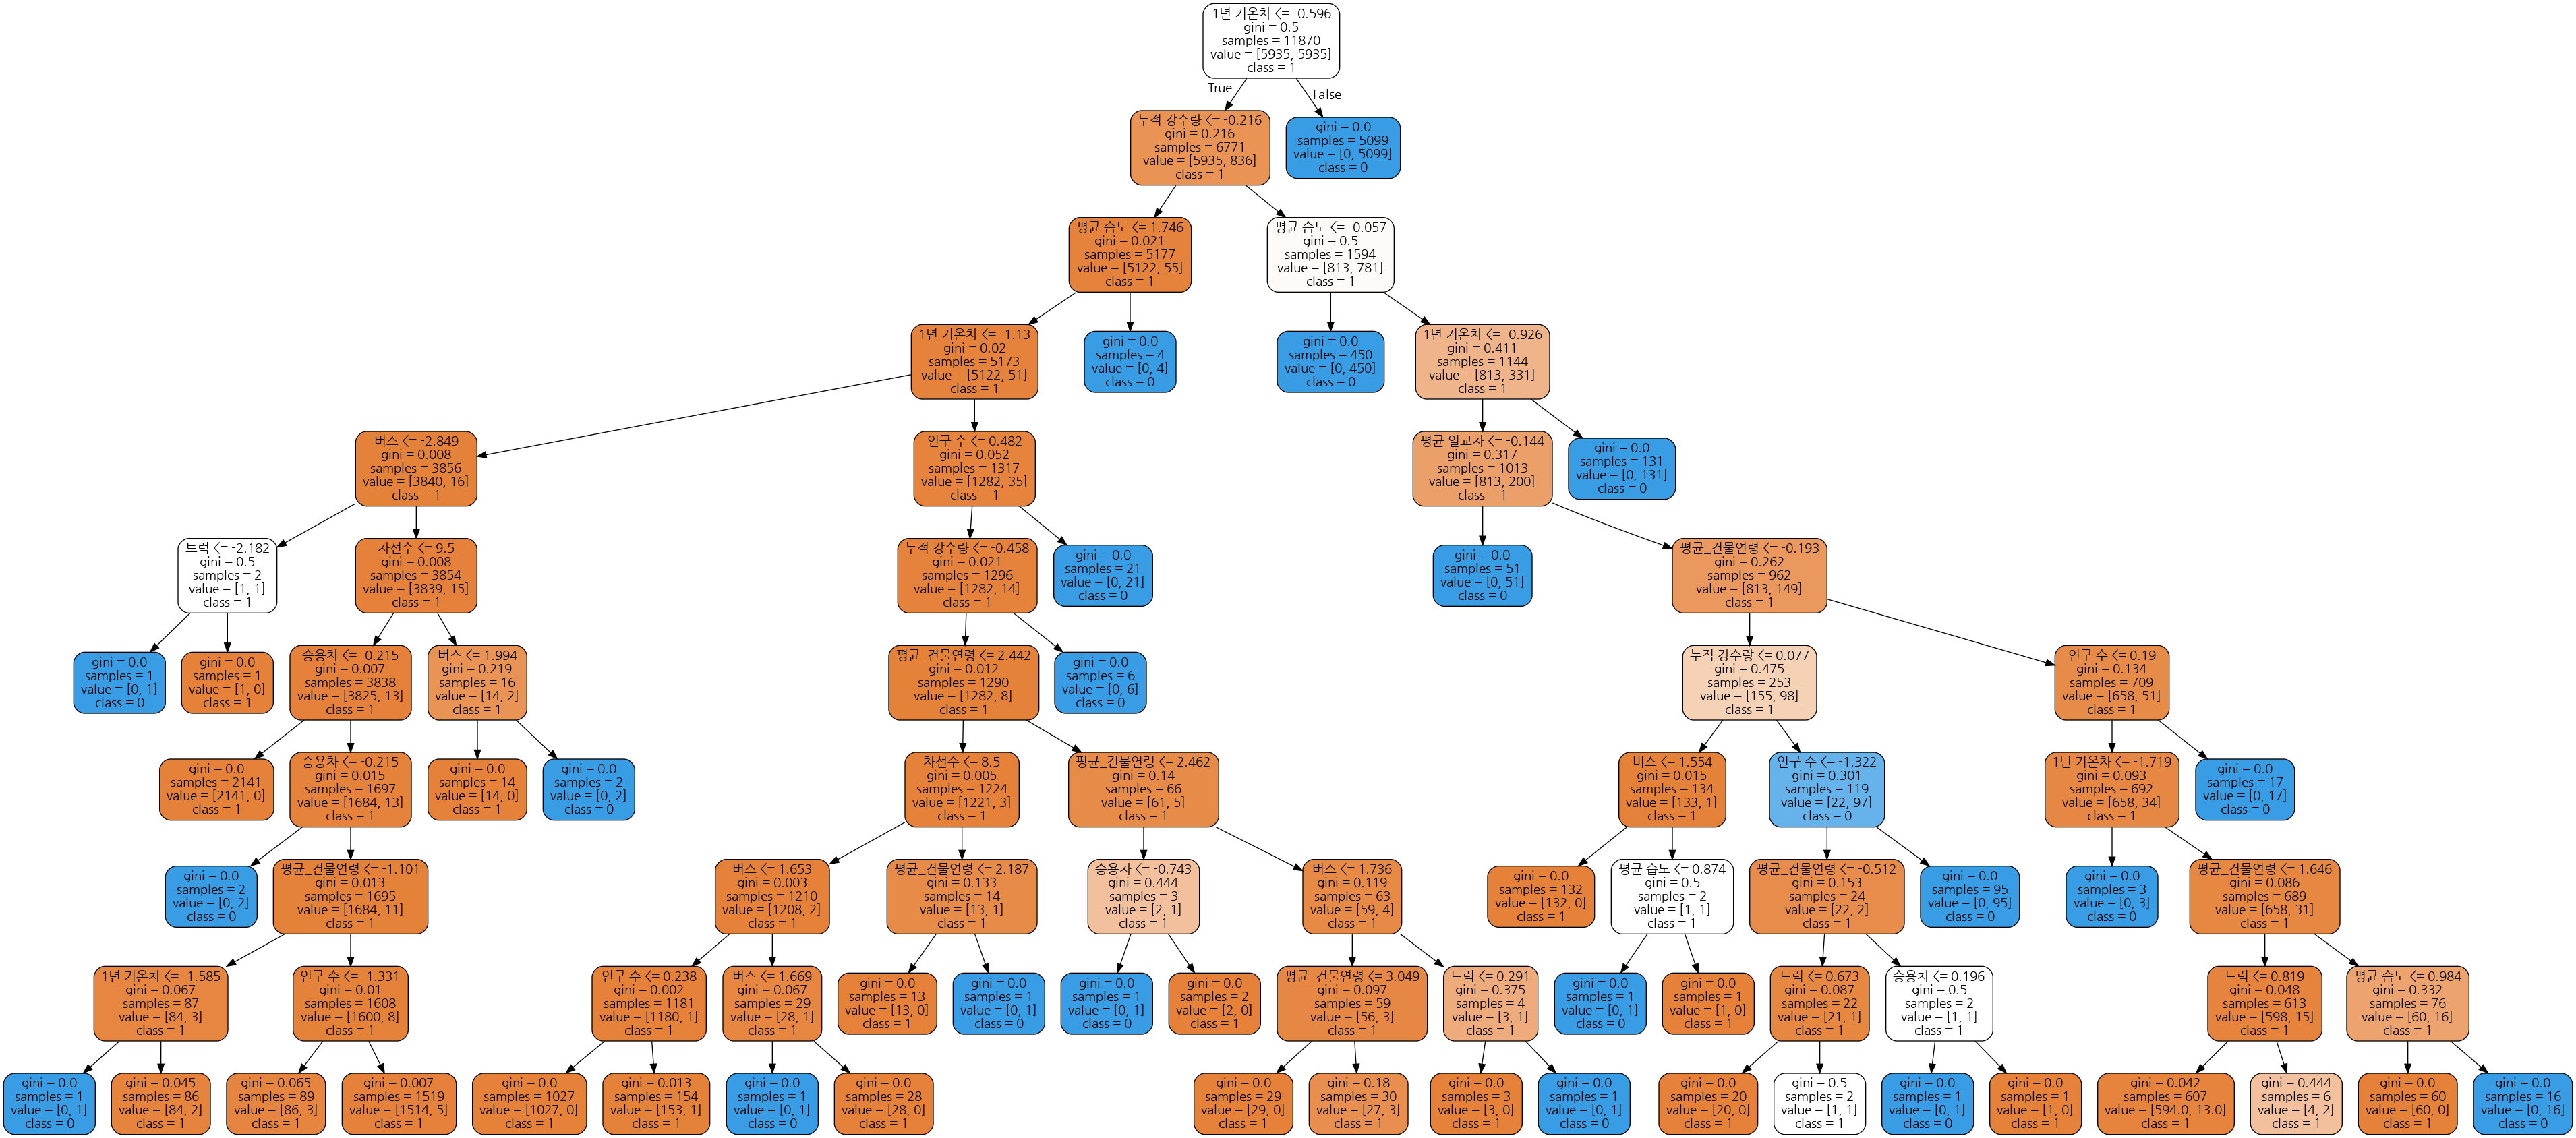

In [ ]:
tree_model_dot = export_graphviz(tree_model_up,
                                 out_file = None,
                                 class_names = [str(cls) for cls in y_train_up.unique()],
                                 feature_names = x_train_up.columns,
                                 rounded = True, filled = True, fontname="NanumGothic")
graph = Source(tree_model_dot)
graph.render("tree_model", format = "png")
Image(filename = "tree_model.png")

### 결과

In [ ]:
print(
    "KNN Accuracy: {:.4f}".format(knn_acc),
    "LDA Accuracy: {:.4f}".format(lda_acc),
    "QDA Accuracy: {:.4f}".format(qda_acc),
    "Tree Accuracy: {:.4f}".format(tree_acc),
    "----------------------",
    "KNN_up Accuracy: {:.4f}".format(knn_acc_up),
    "LDA_up Accuracy: {:.4f}".format(lda_acc_up),
    "QDA_up Accuracy: {:.4f}".format(qda_acc_up),
    "Tree_up Accuracy: {:.4f}".format(tree_acc_up),
    sep = "\n"
)

print("-------------------------------")
print("-------------------------------")

print(
    "KNN AUC: {:.4f}".format(knn_auc),
    "LDA AUC: {:.4f}".format(lda_auc),
    "QDA AUC: {:.4f}".format(qda_auc),
    "Tree AUC: {:.4f}".format(tree_auc),
    "----------------------",
    "KNN_up AUC: {:.4f}".format(knn_roc_up),
    "LDA_up AUC: {:.4f}".format(lda_roc_up),
    "QDA_up AUC: {:.4f}".format(qda_roc_up),
    "Tree_up AUC: {:.4f}".format(tree_roc_up),
    sep = "\n"
)

KNN Accuracy: 0.9755
LDA Accuracy: 0.9106
QDA Accuracy: 0.9539
Tree Accuracy: 0.9933
----------------------
KNN_up Accuracy: 0.9761
LDA_up Accuracy: 0.9139
QDA_up Accuracy: 0.9546
Tree_up Accuracy: 0.9946
-------------------------------
-------------------------------
KNN AUC: 0.9857
LDA AUC: 0.9552
QDA AUC: 0.9900
Tree AUC: 0.9983
----------------------
KNN_up AUC: 0.9859
LDA_up AUC: 0.9566
QDA_up AUC: 0.9900
Tree_up AUC: 0.9976


In [ ]:
Models = ['KNN', 'LDA', 'QDA', 'Tree', 'KNN_up', 'LDA_up', 'QDA_up', 'Tree_up']
Accuracy = [knn_acc, lda_acc, qda_acc, tree_acc, knn_acc_up, lda_acc_up, qda_acc_up, tree_acc_up]
AUC = [knn_auc, lda_auc, qda_auc, tree_auc, knn_roc_up, lda_roc_up, qda_roc_up, tree_roc_up]
acc_max = np.argmax(Accuracy)
print(f"Best Model based on Accuracy : {Models[acc_max]}")
auc_max = np.argmax(AUC)
print(f"Best Model based on AUC : {Models[auc_max]}")


Best Model based on Accuracy : Tree_up
Best Model based on AUC : Tree


In [ ]:
print("---------Tree---------------",
      "Accuracy : {:.4f}".format(tree_acc),
      "AUC : {:.4f}".format(tree_auc),
      "FNR : {:.4f}".format(tree_fnr),
      "Precision : {:.4f}".format(tree_precision),
      "F1 Score : {:.4f}".format(tree_f1),
      sep = "\n")

print("---------Tree_up--------------",
      "Accuracy : {:.4f}".format(tree_acc_up),
      "AUC : {:.4f}".format(tree_auc_up),
      "FNR : {:.4f}".format(tree_fnr_up),
      "Precision : {:.4f}".format(tree_precision_up),
      "F1 Score : {:.4f}".format(tree_f1_up),
      sep = "\n")

---------Tree---------------
Accuracy : 0.9933
AUC : 0.9983
FNR : 0.0148
Precision : 1.0000
F1 Score : 0.9926
---------Tree_up--------------
Accuracy : 0.9950
AUC : 0.9982
FNR : 0.0095
Precision : 0.9986
F1 Score : 0.9945
